In [ ]:
""" 
# you need

paru -S playwright

paru -S libffi7 harfbuzz-icu woff2 libxml2-legacy icu66 hyphen enchant libevdev libgudev libwebp0.5

uv pip install playwright lxml

playwright install 

sudo pacman -S --needed \                                                                          
  ttf-liberation \
  ttf-dejavu \
  noto-fonts \
  noto-fonts-cjk \
  noto-fonts-emoji \
  ttf-ms-fonts

     """

' \n# you need\n\nparu -S playwright\n\nparu -S libffi7 harfbuzz-icu woff2 libxml2-legacy icu66 hyphen enchant libevdev libgudev libwebp0.5\n\nuv pip install playwright lxml\n\nplaywright install \n\n     '

In [1]:
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit

In [2]:
from langchain_community.tools.playwright.utils import (
    create_async_playwright_browser,  # A synchronous browser is available, though it isn't compatible with jupyter.\n",   },
    
)

In [3]:
import nest_asyncio

nest_asyncio.apply()

In [4]:
async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()
tools

[ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/tom/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>),
 NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/tom/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>),
 NavigateBackTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/tom/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>),
 ExtractTextTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/tom/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>),
 ExtractHyperlinksTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/tom/.cache/ms-playwright/chromium-1187/chrome-linux/chrome> version=140.0.7339.16>),
 GetElementsTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=/home/tom/.cache/ms

In [5]:
tools_by_name = {tool.name: tool for tool in tools}
navigate_tool = tools_by_name["navigate_browser"]
get_elements_tool = tools_by_name["get_elements"]

In [ ]:
from langchain_deepseek import ChatDeepSeek
from langchain.agents import create_agent
import asyncio
from langgraph.graph import StateGraph, END


llm = ChatDeepSeek(
    model="deepseek-reasoner",
    temperature=0,
    api_key= "",
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


In [7]:
llm_with_tools = llm.bind_tools(tools)

In [1]:
import nest_asyncio
nest_asyncio.apply()

from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

from langchain_deepseek import ChatDeepSeek
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEndpointEmbeddings
from langchain_qdrant import Qdrant
from langchain_classic.tools.retriever import create_retriever_tool

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import RunnableConfig
import asyncio
import aiosqlite
from typing import Literal


In [2]:
async_browser = create_async_playwright_browser(headless=False)
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
browser_tools = toolkit.get_tools()
print("Loaded browser tools:", [t.name for t in browser_tools])


Loaded browser tools: ['click_element', 'navigate_browser', 'previous_webpage', 'extract_text', 'extract_hyperlinks', 'get_elements', 'current_webpage']


In [ ]:
loader = DirectoryLoader("docs", glob="**/*.pdf", loader_cls=PyMuPDFLoader, show_progress=True)
docs = loader.load()
print(f"Loaded {len(docs)} documents")

splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=150)
documents = splitter.split_documents(docs)
print(f"Split into {len(documents)} chunks")

embeddings = HuggingFaceEndpointEmbeddings(
    model="Qwen/Qwen3-Embedding-8B",
    task="feature-extraction",
    huggingfacehub_api_token="",
)

qdrant = Qdrant.from_existing_collection(
    embeddings,
    path="langchain_local_qdrant_pdf",
    collection_name="my_documents",
)
retriever = qdrant.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever,
    name="retrieve_docs",
    description="Retrieve internal documents for relevant passages."
)


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]
/home/tom/apps/cache/python-envs/langchain/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded 47 documents
Split into 142 chunks


In [4]:
all_tools = [retriever_tool, *browser_tools]
print("Unified tools:", [t.name for t in all_tools])

Unified tools: ['retrieve_docs', 'click_element', 'navigate_browser', 'previous_webpage', 'extract_text', 'extract_hyperlinks', 'get_elements', 'current_webpage']


In [ ]:
llm = ChatDeepSeek(
    model="deepseek-chat",
    temperature=0.2,
    api_key="",
)
llm_with_tools = llm.bind_tools(all_tools)

In [6]:
def call_model(state: MessagesState):
    """The LLM decides whether to use a tool or answer directly."""
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


def route_tools(state: MessagesState) -> Literal["tools", END]:
    """If the LLM made a tool call, go to tools; else, stop."""
    last_message = state["messages"][-1]
    return "tools" if getattr(last_message, "tool_calls", None) else END


tool_node = ToolNode(all_tools)

In [7]:
REWRITE_PROMPT = (
    "You are preparing a query for a retrieval tool called 'retrieve_docs', "
    "which searches internal documents for relevant information.\n\n"
    "Your goal is to restate or expand the question so it captures the user's true intent "
    "and includes any necessary context, keywords, or clarifications.\n"
    "Do NOT answer the question — only rewrite it in a clearer, retrieval-friendly way.\n\n"
    "Original user question:\n"
    "------------------------\n"
    "{question}\n"
    "------------------------\n"
    "Rewritten question:"
)

def rewrite_question(state: MessagesState):
    """Rewrite the user's question to make it clearer for document retrieval."""
    messages = state["messages"]

    # Find most recent human/user message
    user_message = next((m for m in reversed(messages) if m.type == "human"), None)
    if not user_message:
        raise ValueError("No HumanMessage found in state to rewrite.")

    question = user_message.content
    prompt = REWRITE_PROMPT.format(question=question)

    # Invoke your LLM with the rewriting prompt
    response = llm.invoke([{"role": "user", "content": prompt}])

    # Return a proper HumanMessage object
    from langchain_core.messages import HumanMessage
    rewritten_message = HumanMessage(
        content=response.content.strip(),
        additional_kwargs={"rewritten_for": "retrieve_docs"},
    )

    return {"messages": [rewritten_message]}


In [8]:
from typing import Literal
from langchain_core.messages import HumanMessage, ToolMessage

GRADE_PROMPT = (
    "You are evaluating whether the retrieved documents are relevant to the question.\n\n"
    "Question:\n{question}\n\n"
    "Context:\n{context}\n\n"
    "Answer only 'yes' or 'no'."
)

MAX_REWRITES = 3  # safety cap to avoid endless rewrite loops


def grade_documents(state: MessagesState) -> Literal["generate_answer", "rewrite_question", "END"]:
    """Grade relevance of retrieved docs and decide next step."""
    messages = state["messages"]

    # check last tool call
    last_tool_msg = next((m for m in reversed(messages)
                          if isinstance(m, ToolMessage)), None)
    if not last_tool_msg or last_tool_msg.name != "retrieve_docs":
        return "generate_answer"  # skip grading for non-retriever tools

    user_msg = next((m for m in reversed(messages)
                     if isinstance(m, HumanMessage)), None)
    question = user_msg.content if user_msg else ""
    context = last_tool_msg.content if hasattr(last_tool_msg, "content") else ""

    prompt = GRADE_PROMPT.format(question=question, context=context)
    resp = llm.invoke([{"role": "user", "content": prompt}])
    verdict = resp.content.strip().lower()

    # count how many rewrites have already occurred
    rewrite_count = sum(
        1 for m in messages
        if isinstance(m, HumanMessage)
        and m.additional_kwargs.get("rewritten_for") == "retrieve_docs"
    )

    if "yes" in verdict:
        return "generate_answer"
    elif rewrite_count >= MAX_REWRITES:
        # stop gracefully after too many failed attempts
        return "generate_answer"
    else:
        return "rewrite_question"


In [9]:
workflow = StateGraph(MessagesState)

workflow.add_node("LLM", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("rewrite_question", rewrite_question)
workflow.add_node("grade_documents", grade_documents)
#workflow.add_node("generate_answer", generate_answer)

workflow.add_edge(START, "rewrite_question")
workflow.add_edge("rewrite_question", "LLM")
workflow.add_conditional_edges("LLM", route_tools)
workflow.add_conditional_edges(
    "tools",
    grade_documents,  # grading step
    {
        "generate_answer": "LLM",   # replace 'LLM' with 'generate_answer' if llm causes infinite loops (LLM has llm with tools integration while generate_answers is just using llms)
        "rewrite_question": "rewrite_question",
    },
)


In [10]:
async def setup_graph():
    db = await aiosqlite.connect("unified_agent.db")
    from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
    saver = AsyncSqliteSaver(db)
    return workflow.compile(checkpointer=saver)

graph = asyncio.run(setup_graph())
config: RunnableConfig = {"configurable": {"thread_id": "session-1"}}


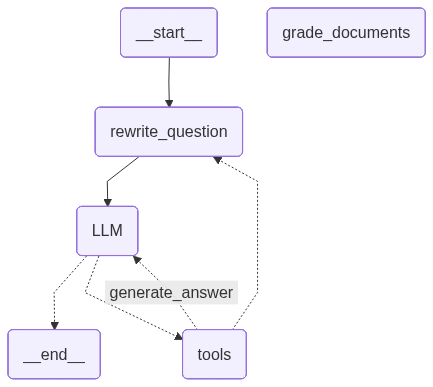

In [11]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
async def main():
    print("\n=== Unified RAG + Playwright Agent Ready ===\n")

    queries = [
        "What are the headers on langchain.com?",
        "Summarize our internal documents about LLM safety techniques.",
    ]

    for q in queries:
        print(f"\n>> USER: {q}\n")
        async for chunk in graph.astream(
            {"messages": [("user", q)]},
            config,
            stream_mode="values",
        ):
            last = chunk["messages"][-1]
            try:
                last.pretty_print()
            except Exception:
                print(getattr(last, "content", last))

    await async_browser.close()


if __name__ == "__main__":
    asyncio.run(main())


=== Unified RAG + Playwright Agent Ready ===


>> USER: What are the headers on langchain.com?

================================ Human Message =================================

What are the headers on langchain.com?
================================ Human Message =================================

What are the main navigation menu headers, section titles, and page headings visible on the homepage and primary landing pages of the website langchain.com?
================================== Ai Message ==================================

I'll help you find the headers on langchain.com. Let me first navigate to the website and then extract the text to identify the headers.
Tool Calls:
  navigate_browser (call_00_1ZQlFTMM1wuIqpw5wJYZyrFi)
 Call ID: call_00_1ZQlFTMM1wuIqpw5wJYZyrFi
  Args:
    url: https://langchain.com
================================= Tool Message =================================
Name: navigate_browser

Navigating to https://langchain.com returned status code 200
==========